# measurement_error

> There are numerous problems that can occur when exogenous variables with measurment error are used in a regression model improperly. This notebook will demonstrate the problems that can occur when measurement error is present in the exogenous variables of a regression model. And some methods for mitigating the problems that can occur when measurement error is present in the exogenous variables of a regression model.

In [ ]:
#| default_exp measurement_error

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
#| hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import xarray as xr

## Survey Data

When working with surveys and samples from a population, it is important to consider the precision of the population parameter estimates. The precision of the population parameter estimates is influenced by the sample size, the sampling design, and the measurement error in the survey data. 

When imprecise measures are used in a regression model, the estimates of the coefficients of the model will be biased and inconsistent. This can occur even when the sampling design is unbiased and respondents answers are entirely accurate. For survey data samples size is often limited, and the sampling design is often complex. This means that the measurement error in the survey data can have a significant impact on the precision of the population parameter estimates.

## Completely random measurement error in a binary outcome variable

Consider the following example:

> A survey is conducted weekly with an average of 500 participants each week. The survey asks participants if they recall seeing a particular brand's advertisement. Survey participents are randomly selected from the population and are well representative of the total population. The survey is conducted by phone and online.

First lets assume that all participants are able to recall the brand's advertisement with 100% accuracy. We would like to estimate the effect of a populations ability to recall the brand's advertisement on the brand's sales. We will use a simple linear regression model to estimate the effect of the populations ability to recall the brand's advertisement on the brand's sales.

Let us simulate the 3 years of survey data.


In [ ]:
#| export
def random_walk_awareness_model(
  periods: list | pd.DatetimeIndex | np.ndarray, # Time periods to simulate
  ) -> pm.Model: # PyMC model for the random walk awareness model
    coords = {
      'Period': periods,
    }
    with pm.Model(coords = coords) as model:
        #Random walk model
        weekly_variation = pm.HalfNormal('weekly_variation', sigma=.1)
        initial_awareness = pm.Normal('initial_awareness', mu=0, sigma=1)
        logit_awareness = pm.GaussianRandomWalk(
          'logit_awareness', 
          sigma=weekly_variation, 
          init_dist=pm.Normal.dist(mu=initial_awareness, sigma=.01), 
          dims="Period")
        
        weekly_shock = pm.HalfNormal('weekly_shock', sigma=.1)
        _noise = pm.Normal('_noise', mu=0, sigma=1, dims="Period")
        awareness = pm.Deterministic('awareness', pm.math.invlogit(logit_awareness + weekly_shock*_noise), dims="Period")
    return model

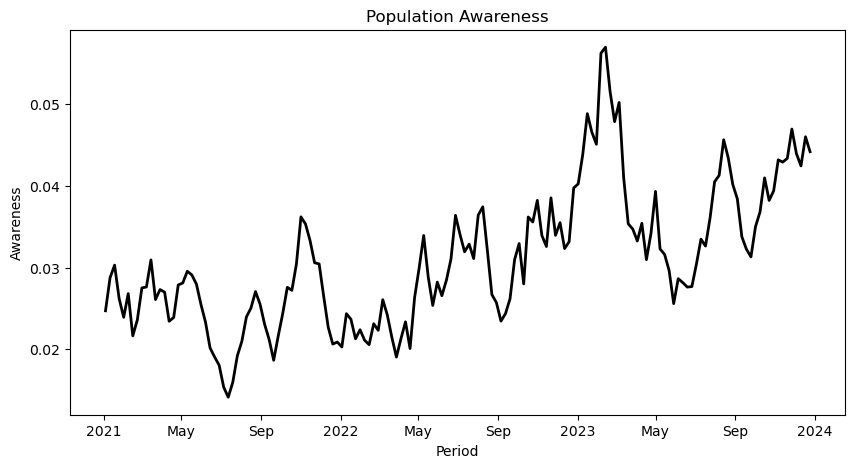

In [ ]:
dates = pd.date_range(start='2021-01-01', periods=156, freq='W-MON')
awareness_model = random_walk_awareness_model(dates)
starting_awareness = 0.025
logit_starting_awareness = np.log(starting_awareness/(1-starting_awareness))
generative_model = pm.do(
  awareness_model, 
  {
    'weekly_variation': .1, 
    'initial_awareness': logit_starting_awareness,
    'weekly_shock': .01
  }
)
population_awareness = pm.draw(generative_model['awareness'], random_seed=42)
population_awareness = xr.DataArray(
  population_awareness,
  dims=['Period'],
  coords={'Period': dates}
)
plt.figure(figsize=(10, 5))
population_awareness.plot(c='k', lw=2)
plt.title('Population Awareness')
plt.ylabel('Awareness')
plt.xlabel('Period');

In [ ]:
#| export
def survey_obs_model(
  population_awareness: xr.DataArray | pm.pytensorf.TensorVariable, # Population awareness
  avg_weekly_participants: float = 500.0, # Average number of participants per week
  coords: dict = None, # Coordinates for the PyMC model
  model: pm.Model = None, # PyMC model to add the survey observation model
  ) -> pm.Model:
    if coords is None:
      assert isinstance(population_awareness, xr.DataArray), "If coords is not provided, population_awareness must be an xarray DataArray"
      coords = {
        'Period': population_awareness['Period'].values,
      }
      population_awareness = population_awareness.values
    try:
      model = pm.modelcontext(model)
    except TypeError:
      model = pm.Model(coords=coords)
    with model:
        N_survey_participant = pm.Poisson('n_survey_participants', avg_weekly_participants, dims="Period")
        N_positive = pm.Binomial('n_positive', N_survey_participant, population_awareness, dims="Period")
    return model

In [ ]:
#| export
def simulate_awareness_survey_data(
  start_date: str = '2020-01-01', # Start date of the survey data
  n_weeks: int = 156, # Number of weeks to simulate
  avg_weekly_participants: float = 500.0, # Average number of participants per week
  weekly_awareness_variation: float = 0.08, # Std. dev. of gaussian inovations for weekly awareness
  starting_population_aware: float = 0.025, # Starting population awareness
  weekly_shock: float = 0.01, # Std. dev. of gaussian noise for weekly deviation from random walk
  random_seed: int = 42, # Random seed for reproducibility
) -> xr.Dataset: # Simulated awareness survey data as an xarray dataset
  dates = pd.date_range(start=start_date, periods=n_weeks, freq='W-MON')
  awareness_model = random_walk_awareness_model(dates)
  gen_model = pm.do(
    awareness_model, 
    {
      'weekly_variation': weekly_awareness_variation, 
      'initial_awareness': np.log(starting_population_aware/(1-starting_population_aware)),
      'weekly_shock': .01
    }
  )
  
  with gen_model:
    survey_obs_model(gen_model['awareness'], avg_weekly_participants=avg_weekly_participants, coords={'Period': dates})
    trace = pm.sample_prior_predictive(1, random_seed=random_seed)
  
  trace = trace.prior.isel(chain=0, draw=0).drop_vars('chain').drop_vars('draw')
  return trace.assign(estimated_awareness = trace['n_positive']/trace['n_survey_participants'])


In [ ]:
#| export
def plot_survey_sim_data(
  data: xr.Dataset, # Simulated survey data must contain 'awareness' and 'estimated_awareness' variables
) -> None: # Plot of the simulated survey data
    plt.figure(figsize=(10, 5))
    data.estimated_awareness.plot.scatter(x='Period', c='lightblue', label='Simulated Survey Data')
    data.awareness.plot(c='k', lw=2, ls='--', label="Population Awareness")
    plt.legend()
    plt.title('Simulated Awareness Survey Data');

Sampling: [_noise, logit_awareness, n_positive, n_survey_participants]


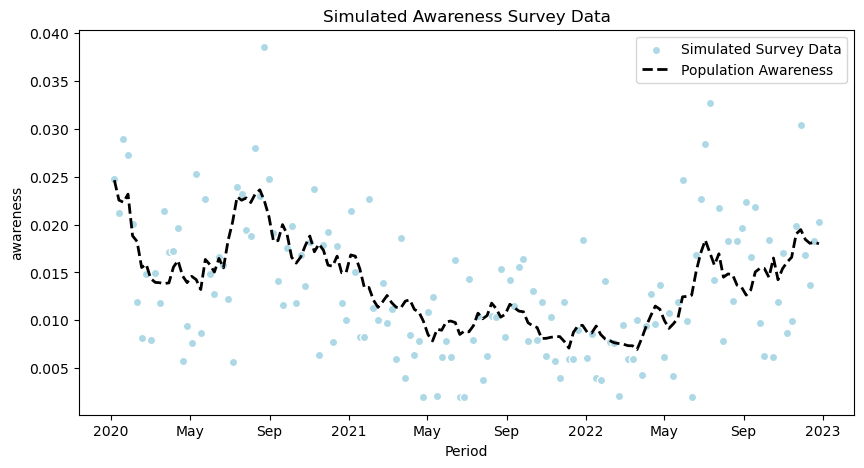

In [ ]:
trace = simulate_awareness_survey_data(random_seed=23)
plot_survey_sim_data(trace)

## Let's simulate some sales data

The sales data is simulated using the following equation:

$$
\begin{align*}
log(S_t) &= \beta \text{pop\_awareness}_t + \alpha + \epsilon_t \\
\epsilon_t &\sim N(0, \sigma^2)
\end{align*}
$$

Lets see if the true coeff $\beta$ can be estimated using the simulated data.

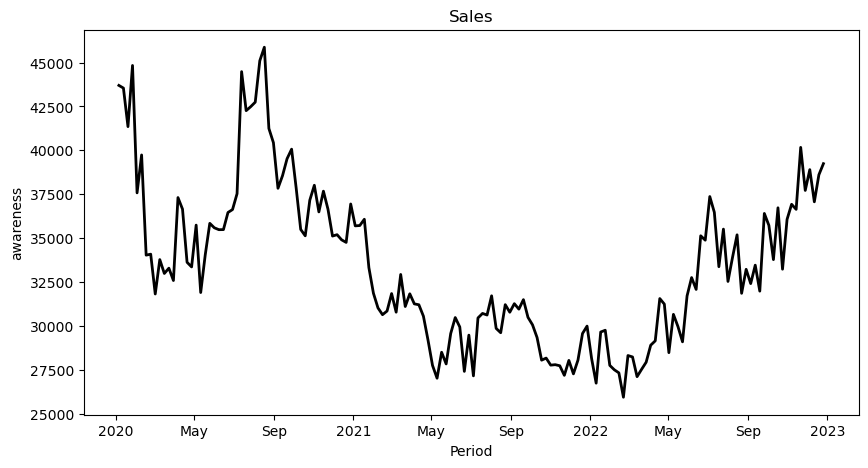

In [ ]:
ACTUAL_AWARENESS_COEFF = 30
log_sales = trace.awareness*ACTUAL_AWARENESS_COEFF + 10 + np.random.normal(0, 0.03, trace.awareness.shape)
sales = np.exp(log_sales)
plt.figure(figsize=(10, 5))
sales.plot(c='k', lw=2)
plt.title('Sales');

### The naive model

Let's try ignoring the data generation process and fit a simple linear regression model to the data.

In [ ]:
naive_model = sm.OLS(log_sales.to_series(), sm.add_constant(trace.estimated_awareness.to_series())).fit(cov_type="HAC", cov_kwds={'maxlags':1})
naive_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              awareness   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     78.79
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           1.66e-15
Time:                        08:30:37   Log-Likelihood:                 133.76
No. Observations:                 156   AIC:                            -263.5
Df Residuals:                     154   BIC:                            -257.4
Df Model:                           1                                         
Covariance Type:                  HAC                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.2517      0.020    522.268      0.000      10.213      10.290
estimated_awareness    11.7063      1.319      8.876      0.000       9.121      14.291
==============================================================================
Omnibus:                       13.566   Durbin-Watson:                   1.019
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                5.624
Skew:                           0.195   Prob(JB):                       0.0601
Kurtosis:                       2.155   Cond. No.                         142.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

We can see that the estimated coefficient is biased. The true coefficient for the effect of the populations ability to recall the brand's advertisement on the brand's sales is 30. The estimated coefficient is much less.

### Next the simple moving average model

Let's try a simple moving average model to see if we can improve the estimate of the coefficient. We will ignore the data generation process and take the moving average of the estimated awareness directly.

In [ ]:
moving_avg_awareness = trace.estimated_awareness.rolling(Period=5).mean().shift(Period=-2)
moving_avg_model = sm.OLS(log_sales.to_series()[2:-2], sm.add_constant(moving_avg_awareness.to_series()[2:-2])).fit(cov_type="HAC", cov_kwds={'maxlags':1})
moving_avg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              awareness   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     221.3
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           2.51e-31
Time:                        08:30:37   Log-Likelihood:                 190.63
No. Observations:                 152   AIC:                            -377.3
Df Residuals:                     150   BIC:                            -371.2
Df Model:                           1                                         
Covariance Type:                  HAC                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.1069      0.019    538.408      0.000      10.070      10.144
estimated_awareness    22.4968      1.512     14.877      0.000      19.533      25.461
==============================================================================
Omnibus:                        1.027   Durbin-Watson:                   0.812
Prob(Omnibus):                  0.598   Jarque-Bera (JB):                1.103
Skew:                           0.188   Prob(JB):                        0.576
Kurtosis:                       2.820   Cond. No.                         209.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

Already we are doing better than the naive model. The estimated coefficient is closer to the true coefficient. However, the estimated coefficient is still biased.

### Moving Average (Correctly this time)

Let's try a moving average model again, but this time we will take the moving average of the number of survey participants and the number of positive results before dividing each.

In [ ]:
moving_sum_n_positive = trace.n_positive.rolling(Period=5).sum().shift(Period=-2)
moving_sum_n_participants = trace.n_survey_participants.rolling(Period=5).sum().shift(Period=-2)
moving_avg_awareness = moving_sum_n_positive/moving_sum_n_participants
moving_avg_model = sm.OLS(log_sales.to_series()[2:-2], sm.add_constant(moving_avg_awareness.to_series()[2:-2])).fit(cov_type="HAC", cov_kwds={'maxlags':1})
moving_avg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              awareness   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     228.7
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           5.69e-32
Time:                        08:30:37   Log-Likelihood:                 190.48
No. Observations:                 152   AIC:                            -377.0
Df Residuals:                     150   BIC:                            -370.9
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.1055      0.019    540.775      0.000      10.069      10.142
0             22.6497      1.498     15.123      0.000      19.714      25.585
==============================================================================
Omnibus:                        1.312   Durbin-Watson:                   0.810
Prob(Omnibus):                  0.519   Jarque-Bera (JB):                1.330
Skew:                           0.219   Prob(JB):                        0.514
Kurtosis:                       2.866   Cond. No.                         210.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

This model is only slightly better than the simple moving average model. The estimated coefficient is still biased.

### Latent Variable Model
Let us now try to first estimate the population level awareness using a bayesian model and then use the estimated population level awareness in the regression model.

In [ ]:
dates = trace["Period"].values
awareness_model = random_walk_awareness_model(dates)

  
with awareness_model as survey_model:
    survey_obs_model(awareness_model['awareness'], avg_weekly_participants=500, coords={'Period': dates})

with pm.observe(
  pm.do(
    survey_model, 
    {'n_survey_participants': trace.n_survey_participants.values} # apply the number of survey participants
    ), 
  {'n_positive': trace.n_positive.values} # observe the number of positive responses
  ):
    obs_trace = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weekly_variation, initial_awareness, logit_awareness, weekly_shock, _noise]


Output()

In [ ]:
obs_trace.posterior['awareness'].mean(dim=('draw','chain')).plot(c='k', lw=2, label='Estimated Awareness')
trace['estimated_awareness'].plot(c='lightblue', label='Survey Data')
plt.title('Estimated Awareness')
plt.legend();

In [ ]:
estimated_model = sm.OLS(log_sales.to_series(), sm.add_constant(obs_trace.posterior['awareness'].mean(dim=('chain', 'draw')).to_series())).fit(cov_type="HAC", cov_kwds={'maxlags':1})
estimated_model.summary()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()